This notebook trains an advanced tree-based fraud detection model (XGBoost) using hypothesis-driven behavioral features, anonymized V-features, and identity enrichment, under a strict time-based validation setup. The focus is performance improvement while preserving explainability and production readiness.

In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/3a/d8/4d4ae25452577f2dfabc66b60e712e7c01f9fe6c389fa88c546c2f427c4d/xgboost-3.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 162.5 kB/s eta 0:07:23
   ---------------------------------------- 0.0/72.0 MB 186.2 kB/s eta 0:06:27
   ---------------------------------------- 0.0/72.0 MB 195.7 kB/s eta 0:06:08
   ---------------------------------------- 0.1/72.0 MB 454.0 kB/s eta 0:02:39
   ---------------------------------------- 0.2/72.0 MB 958.6 kB/s eta 0:01:15
   ---------------------------------------- 0.3/72.0 MB 862.0 kB/s eta 0:01:24
   --------------------------------------


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score
import xgboost as xgb

import matplotlib.pyplot as plt


In [4]:
trans = pd.read_csv("../data/train_transaction.csv")
ident = pd.read_csv("../data/train_identity.csv")

# always sort by time
trans = trans.sort_values("TransactionDT").reset_index(drop=True)


In [5]:
# UID
trans["uid"] = trans["card1"].astype(str) + "_" + trans["addr1"].astype(str)

# Velocity
trans["uid_txn_count"] = trans.groupby("uid").cumcount()

# Abnormal amount
uid_avg_amt = (
    trans.groupby("uid")["TransactionAmt"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

trans["uid_avg_amt"] = uid_avg_amt
trans["amt_vs_uid_avg"] = trans["TransactionAmt"] / trans["uid_avg_amt"]

# Recency
trans["uid_prev_dt"] = trans.groupby("uid")["TransactionDT"].shift()
trans["uid_time_since_last"] = trans["TransactionDT"] - trans["uid_prev_dt"]

# Identity presence
trans["has_identity"] = trans["TransactionID"].isin(
    ident["TransactionID"]
).astype(int)


In [6]:
m_cols = [c for c in trans.columns if c.startswith("M")]

for c in m_cols:
    trans[c] = trans[c].map({"T": 1, "F": 0}).fillna(-1)


In [7]:
v_cols = [c for c in trans.columns if c.startswith("V")]


In [8]:
trans = trans.merge(
    ident,
    on="TransactionID",
    how="left"
)


In [9]:
identity_cols = [
    "DeviceType",
    "DeviceInfo"
]

for c in identity_cols:
    trans[c] = trans[c].astype("category")


In [10]:
for c in identity_cols:
    trans[c] = trans[c].cat.codes


In [11]:
feature_cols = (
    [
        "TransactionAmt",
        "uid_txn_count",
        "amt_vs_uid_avg",
        "uid_time_since_last",
        "has_identity"
    ]
    + m_cols
    + v_cols
    + identity_cols
)

target = "isFraud"


In [12]:
split_idx = int(len(trans) * 0.8)

train_df = trans.iloc[:split_idx]
val_df   = trans.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_val = val_df[feature_cols]
y_val = val_df[target]


In [13]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)


[0]	validation_0-auc:0.76518
[50]	validation_0-auc:0.84982
[100]	validation_0-auc:0.85707
[150]	validation_0-auc:0.86130
[200]	validation_0-auc:0.86428
[250]	validation_0-auc:0.86681
[299]	validation_0-auc:0.86806


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [14]:
val_preds = xgb_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, val_preds)
pr_auc = average_precision_score(y_val, val_preds)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")


ROC-AUC: 0.8681
PR-AUC : 0.4542


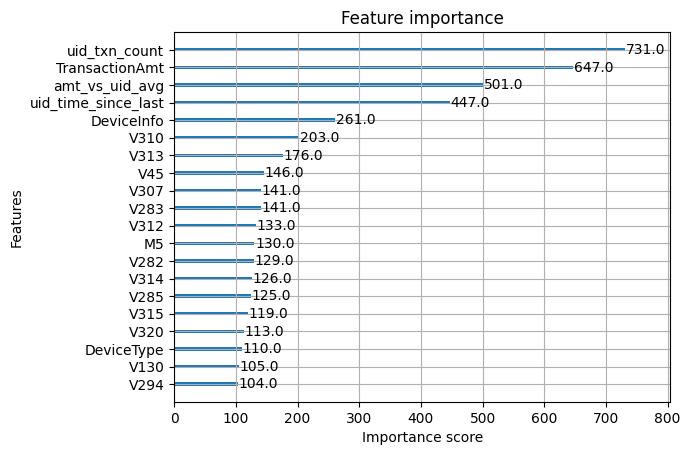

In [16]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()


In [15]:
import joblib

joblib.dump(xgb_model, "../artifacts/xgb_model_v1.pkl")
joblib.dump(feature_cols, "../artifacts/xgb_features_v1.pkl")


['../artifacts/xgb_features_v1.pkl']